## Import Packages

In [1]:
from spo.data import knapsack, dataset
from spo.model import knapsackModel
from spo.func import SPOPlus
from spo.eval import unambSPO

In [2]:
import time
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader

In [3]:
torch.manual_seed(135)

## Init Data 

In [4]:
# generate data for grid network (features and costs)
m = 48 # number of items
n = 1000 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
weights, x, c = knapsack.genData(n+1000, p, m, deg=deg, cor=False)

## Build Model 

In [5]:
# model for knapscak
cap = 30
ks_model = knapsackModel(weights, cap)


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-06-13
Using license file C:\Users\Apocrypse\gurobi.lic


## Training

In [6]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m)
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [7]:
def train(dataloader, opt_model, num_epochs, learning_rate, l1_lambda=1e-3):
    """
    train model with SPO+ Loss
    args:
      dataloader: dataloader from optDataSet
      model: optModel
      num_epochs: number of epochs
      l2_lambda: l2 regularization parameter
    """
    print('Training...')
    # init model
    lr = LinearRegression()
    # cuda
    if torch.cuda.is_available():
        lr = lr.cuda()
    # training mode
    lr.train()
    # set optimizer
    optimizer = torch.optim.Adam(lr.parameters(), lr=learning_rate)
    # set SPO+ Loss as criterion
    criterion = SPOPlus()
    # train
    time.sleep(1)
    for epoch in tqdm(range(num_epochs)):
        # load data
        for i, data in enumerate(dataloader):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # forward pass
            cp = lr(x)
            loss = criterion.apply(opt_model, cp, c, w, z).mean()
            # l1 reg
            l1_reg = torch.abs(cp - c).sum(dim=1).mean()
            loss += l1_lambda * l1_reg
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return lr

## Experiments

### Training Set Size = 100, Noise Half−width = 0

In [8]:
# set up
n = 100 # number of data
p = 5 # size of feature
e = 0 # noise half−width
cap = 30 # capacity
degs = [1, 2, 4, 6] # list of param deg

In [9]:
# init DataFrame
df1 = pd.DataFrame(columns = degs)

In [10]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        weights, x, c = knapsack.genData(n+1000, p, m, deg=deg, noise_width=e, seed=i)
        c = - c
        # build model
        ks_model = knapsackModel(weights, cap)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        ks_dataset_train = dataset.optDataset(ks_model, x_train, c_train)
        ks_dataset_test = dataset.optDataset(ks_model, x_test, c_test)
        # get data loader
        batch_size = 32
        ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
        ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 5e-3 * deg 
        num_epochs = 1000
        lr = train(ks_loader_train, ks_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, ks_model, ks_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df1 = df1.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 299.28it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.44it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:39<00:00,  2.94it/s]


Normalized SPO Loss: 0.20%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 333.12it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.75it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:54<00:00,  2.82it/s]


Normalized SPO Loss: 0.36%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 327.12it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.58it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:34<00:00,  2.99it/s]


Normalized SPO Loss: 0.98%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 333.65it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.00it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:33<00:00,  3.00it/s]


Normalized SPO Loss: 2.73%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 357.15it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 330.91it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:33<00:00,  3.00it/s]


Normalized SPO Loss: 1.11%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 303.84it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 298.43it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:30<00:00,  3.02it/s]


Normalized SPO Loss: 0.54%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 308.02it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.59it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:35<00:00,  2.98it/s]


Normalized SPO Loss: 0.83%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 345.35it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 327.70it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:39<00:00,  2.95it/s]


Normalized SPO Loss: 1.38%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 314.32it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.03it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:34<00:00,  2.99it/s]


Normalized SPO Loss: 0.39%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 335.34it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.61it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:47<00:00,  2.88it/s]


Normalized SPO Loss: 0.39%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 229.74it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.06it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:47<00:00,  2.88it/s]


Normalized SPO Loss: 0.72%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 350.59it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 325.00it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:33<00:00,  3.00it/s]


Normalized SPO Loss: 1.85%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 306.70it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 339.36it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:27<00:00,  3.05it/s]


Normalized SPO Loss: 4.10%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 296.82it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.77it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:30<00:00,  3.03it/s]


Normalized SPO Loss: 1.03%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 263.14it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 266.72it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:39<00:00,  2.94it/s]


Normalized SPO Loss: 0.73%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 333.14it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.91it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:33<00:00,  3.00it/s]


Normalized SPO Loss: 1.25%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 330.84it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.63it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:52<00:00,  2.84it/s]


Normalized SPO Loss: 3.06%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 265.26it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 311.05it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:39<00:00,  2.94it/s]


Normalized SPO Loss: 0.86%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 316.30it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.82it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:28<00:00,  3.05it/s]


Normalized SPO Loss: 1.08%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 350.56it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.34it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:23<00:00,  3.09it/s]


Normalized SPO Loss: 1.99%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 349.36it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 341.86it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:22<00:00,  3.10it/s]


Normalized SPO Loss: 0.35%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 260.53it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 287.18it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:14<00:00,  3.18it/s]


Normalized SPO Loss: 0.40%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 312.26it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 287.41it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:20<00:00,  3.12it/s]


Normalized SPO Loss: 0.78%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 354.30it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.48it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:23<00:00,  3.09it/s]


Normalized SPO Loss: 2.08%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 306.63it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.96it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:16<00:00,  3.16it/s]


Normalized SPO Loss: 0.47%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 335.34it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.48it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:13<00:00,  3.19it/s]


Normalized SPO Loss: 0.44%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 355.56it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 366.21it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:57<00:00,  3.37it/s]


Normalized SPO Loss: 0.84%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 333.11it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.73it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:00<00:00,  3.33it/s]


Normalized SPO Loss: 2.22%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 338.77it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 362.37it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:59<00:00,  3.34it/s]


Normalized SPO Loss: 3.93%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 382.65it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 353.93it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:00<00:00,  3.33it/s]


Normalized SPO Loss: 1.60%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 276.22it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.75it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:00<00:00,  3.33it/s]


Normalized SPO Loss: 1.36%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 367.27it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.53it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:17<00:00,  3.15it/s]


Normalized SPO Loss: 1.64%



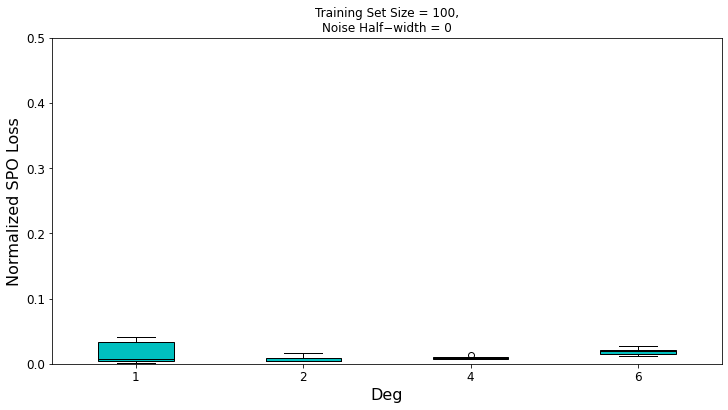

In [11]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df1, boxprops=dict(facecolor='c', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 100,\nNoise Half−width = 0')
plt.show()

### Training Set Size = 100, Noise Half−width = 0.5

In [12]:
# set
n = 100 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [13]:
# init DataFrame
df2 = pd.DataFrame(columns = degs)

In [14]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        weights, x, c = knapsack.genData(n+1000, p, m, deg=deg, noise_width=e, seed=i)
        c = - c
        # build model
        ks_model = knapsackModel(weights, cap)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        ks_dataset_train = dataset.optDataset(ks_model, x_train, c_train)
        ks_dataset_test = dataset.optDataset(ks_model, x_test, c_test)
        # get data loader
        batch_size = 32
        ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
        ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 5e-3 * deg 
        num_epochs = 1000
        lr = train(ks_loader_train, ks_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, ks_model, ks_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df2 = df2.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 359.39it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 360.54it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:01<00:00,  3.31it/s]


Normalized SPO Loss: 10.87%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 361.94it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 381.01it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:36<00:00,  3.62it/s]


Normalized SPO Loss: 10.11%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 397.85it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 389.85it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:25<00:00,  3.77it/s]


Normalized SPO Loss: 8.99%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 364.64it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 390.29it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:39<00:00,  3.58it/s]


Normalized SPO Loss: 9.85%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 374.19it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 382.91it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:27<00:00,  3.74it/s]


Normalized SPO Loss: 14.82%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 351.85it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 355.43it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:24<00:00,  3.78it/s]


Normalized SPO Loss: 10.88%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 335.34it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 384.90it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:28<00:00,  3.72it/s]


Normalized SPO Loss: 9.13%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 349.43it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 392.12it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:26<00:00,  3.75it/s]


Normalized SPO Loss: 7.77%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 339.92it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 387.58it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:26<00:00,  3.75it/s]


Normalized SPO Loss: 12.53%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 349.43it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 385.19it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:33<00:00,  3.66it/s]


Normalized SPO Loss: 11.32%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 197.77it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 244.14it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:05<00:00,  3.28it/s]


Normalized SPO Loss: 10.00%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 326.64it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 383.57it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:32<00:00,  3.67it/s]


Normalized SPO Loss: 9.77%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 374.09it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 381.24it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:28<00:00,  3.73it/s]


Normalized SPO Loss: 14.67%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 350.59it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 383.13it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:32<00:00,  3.67it/s]


Normalized SPO Loss: 11.09%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 378.41it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.09it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:32<00:00,  3.67it/s]


Normalized SPO Loss: 9.11%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 334.20it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 377.58it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:30<00:00,  3.70it/s]


Normalized SPO Loss: 8.18%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 335.34it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 343.03it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:26<00:00,  3.76it/s]


Normalized SPO Loss: 12.78%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 384.12it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 381.54it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:29<00:00,  3.71it/s]


Normalized SPO Loss: 11.43%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 346.92it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 382.55it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:31<00:00,  3.68it/s]


Normalized SPO Loss: 10.17%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 388.59it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 379.23it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:34<00:00,  3.65it/s]


Normalized SPO Loss: 10.72%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 362.01it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 365.14it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:27<00:00,  3.74it/s]


Normalized SPO Loss: 12.38%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 342.18it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 366.52it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:24<00:00,  3.78it/s]


Normalized SPO Loss: 10.26%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 344.51it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 372.37it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:34<00:00,  3.64it/s]


Normalized SPO Loss: 9.10%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 361.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.32it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:42<00:00,  3.54it/s]


Normalized SPO Loss: 9.17%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 367.35it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 379.75it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:27<00:00,  3.74it/s]


Normalized SPO Loss: 16.36%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 321.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 379.08it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:30<00:00,  3.70it/s]


Normalized SPO Loss: 13.18%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 351.78it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 385.80it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:27<00:00,  3.74it/s]


Normalized SPO Loss: 10.90%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 336.44it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 384.00it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:34<00:00,  3.65it/s]


Normalized SPO Loss: 10.90%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 320.34it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 354.93it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:29<00:00,  3.70it/s]


Normalized SPO Loss: 14.84%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 401.02it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 381.60it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:31<00:00,  3.68it/s]


Normalized SPO Loss: 12.37%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 372.11it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 384.63it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:34<00:00,  3.64it/s]


Normalized SPO Loss: 9.39%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 341.10it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 389.49it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:32<00:00,  3.67it/s]


Normalized SPO Loss: 9.49%



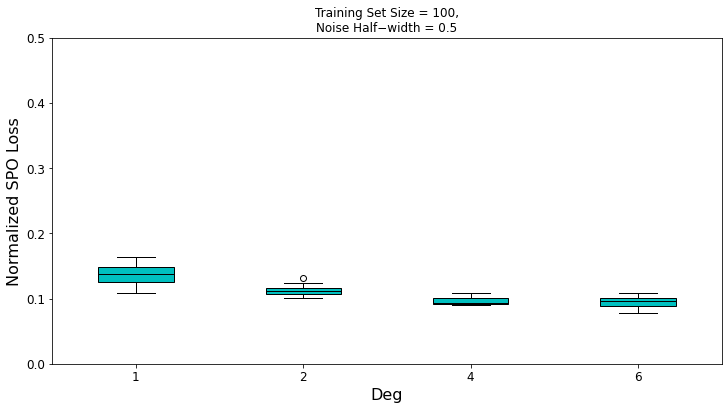

In [15]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df2, boxprops=dict(facecolor='c', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 100,\nNoise Half−width = 0.5')
plt.show()

## Training Set Size = 1000, Noise Half−width = 0 

In [16]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [17]:
# init DataFrame
df3 = pd.DataFrame(columns = degs)

In [18]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        weights, x, c = knapsack.genData(n+1000, p, m, deg=deg, noise_width=e, seed=i)
        c = - c
        # build model
        ks_model = knapsackModel(weights, cap)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        ks_dataset_train = dataset.optDataset(ks_model, x_train, c_train)
        ks_dataset_test = dataset.optDataset(ks_model, x_test, c_test)
        # get data loader
        batch_size = 32
        ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
        ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 5e-3 * deg 
        num_epochs = 200
        lr = train(ks_loader_train, ks_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, ks_model, ks_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df3 = df3.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 371.22it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 384.13it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:48<00:00,  2.64s/it]


Normalized SPO Loss: 0.08%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 381.97it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 380.27it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:56<00:00,  2.68s/it]


Normalized SPO Loss: 0.15%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 366.61it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 367.68it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:55<00:00,  2.68s/it]


Normalized SPO Loss: 0.25%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 381.53it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 385.20it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [09:01<00:00,  2.71s/it]


Normalized SPO Loss: 0.80%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 390.47it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 385.68it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:48<00:00,  2.64s/it]


Normalized SPO Loss: 0.10%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 383.36it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 362.37it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:53<00:00,  2.67s/it]


Normalized SPO Loss: 0.15%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 377.94it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 387.82it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:56<00:00,  2.68s/it]


Normalized SPO Loss: 0.27%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 374.67it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 376.61it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:57<00:00,  2.69s/it]


Normalized SPO Loss: 0.56%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 388.19it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 391.82it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:58<00:00,  2.69s/it]


Normalized SPO Loss: 0.12%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 388.03it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 391.67it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:51<00:00,  2.66s/it]


Normalized SPO Loss: 0.18%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 398.52it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 400.43it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:51<00:00,  2.66s/it]


Normalized SPO Loss: 0.28%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 386.84it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 392.59it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [09:00<00:00,  2.70s/it]


Normalized SPO Loss: 0.62%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 388.04it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 392.91it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:57<00:00,  2.69s/it]


Normalized SPO Loss: 0.10%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 388.97it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 381.53it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [09:02<00:00,  2.71s/it]


Normalized SPO Loss: 0.13%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 383.37it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 375.70it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:46<00:00,  2.63s/it]


Normalized SPO Loss: 0.23%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 377.64it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 377.79it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [08:57<00:00,  2.69s/it]


Normalized SPO Loss: 0.44%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 384.78it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 368.55it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [09:26<00:00,  2.83s/it]


Normalized SPO Loss: 0.09%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 380.89it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 369.68it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [09:07<00:00,  2.74s/it]


Normalized SPO Loss: 0.17%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 364.04it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 357.52it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [09:31<00:00,  2.86s/it]


Normalized SPO Loss: 0.25%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 364.09it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 354.05it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [09:20<00:00,  2.80s/it]


Normalized SPO Loss: 0.57%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 370.03it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 374.87it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [09:26<00:00,  2.83s/it]


Normalized SPO Loss: 0.09%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.89it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 343.43it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:15<00:00,  3.08s/it]


Normalized SPO Loss: 0.11%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 251.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 256.37it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:54<00:00,  3.27s/it]


Normalized SPO Loss: 0.28%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 343.47it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.59it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:07<00:00,  3.04s/it]


Normalized SPO Loss: 0.60%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 320.02it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 224.55it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [09:38<00:00,  2.89s/it]


Normalized SPO Loss: 0.27%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 353.02it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 356.19it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [09:49<00:00,  2.95s/it]


Normalized SPO Loss: 0.20%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 286.31it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 275.54it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:48<00:00,  3.24s/it]


Normalized SPO Loss: 0.38%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.50it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.63it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:45<00:00,  3.23s/it]


Normalized SPO Loss: 0.81%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.92it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.15it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:43<00:00,  3.22s/it]


Normalized SPO Loss: 0.04%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.61it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 273.81it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:44<00:00,  3.22s/it]


Normalized SPO Loss: 0.13%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.00it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.97it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:47<00:00,  3.24s/it]


Normalized SPO Loss: 0.31%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 263.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 270.63it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:45<00:00,  3.23s/it]


Normalized SPO Loss: 0.65%



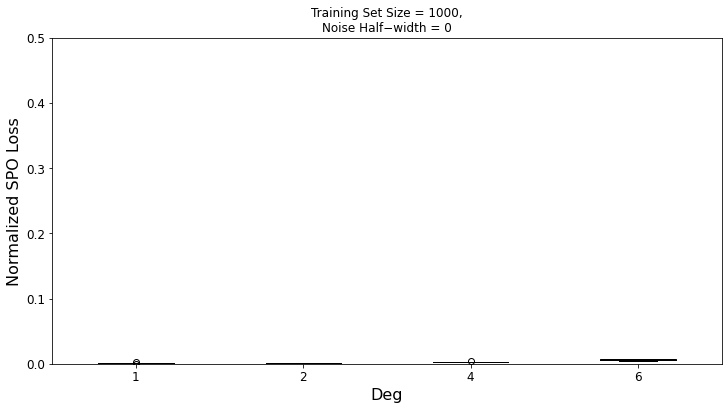

In [19]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df3, boxprops=dict(facecolor='c', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 1000,\nNoise Half−width = 0')
plt.show()

## Training Set Size = 1000, Noise Half−width = 0.5 

In [20]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [21]:
# init DataFrame
df4 = pd.DataFrame(columns = degs)

In [22]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        weights, x, c = knapsack.genData(n+1000, p, m, deg=deg, noise_width=e, seed=i)
        c = - c
        # build model
        ks_model = knapsackModel(weights, cap)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        ks_dataset_train = dataset.optDataset(ks_model, x_train, c_train)
        ks_dataset_test = dataset.optDataset(ks_model, x_test, c_test)
        # get data loader
        batch_size = 32
        ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
        ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 5e-3 * deg 
        num_epochs = 200
        lr = train(ks_loader_train, ks_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, ks_model, ks_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df4 = df4.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 333.89it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 333.45it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:39<00:00,  3.20s/it]


Normalized SPO Loss: 10.05%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 327.24it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.27it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:48<00:00,  3.24s/it]


Normalized SPO Loss: 8.88%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.85it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.28it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:56<00:00,  3.28s/it]


Normalized SPO Loss: 7.51%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.02it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.66it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [11:07<00:00,  3.34s/it]


Normalized SPO Loss: 7.18%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.91it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 322.09it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:39<00:00,  3.20s/it]


Normalized SPO Loss: 12.50%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.46it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.41it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:57<00:00,  3.29s/it]


Normalized SPO Loss: 9.33%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 311.20it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.71it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [11:11<00:00,  3.36s/it]


Normalized SPO Loss: 7.42%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.47it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.43it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:52<00:00,  3.26s/it]


Normalized SPO Loss: 6.58%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 263.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 261.86it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:52<00:00,  3.26s/it]


Normalized SPO Loss: 11.17%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.16it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.83it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:55<00:00,  3.28s/it]


Normalized SPO Loss: 10.27%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.47it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 325.97it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:58<00:00,  3.29s/it]


Normalized SPO Loss: 8.55%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 261.86it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 276.60it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:53<00:00,  3.27s/it]


Normalized SPO Loss: 7.84%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.80it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.88it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:47<00:00,  3.24s/it]


Normalized SPO Loss: 10.92%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.22it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.84it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:49<00:00,  3.25s/it]


Normalized SPO Loss: 9.74%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 270.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 268.31it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [11:00<00:00,  3.30s/it]


Normalized SPO Loss: 7.73%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.01it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 320.45it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:55<00:00,  3.28s/it]


Normalized SPO Loss: 7.05%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.71it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.61it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:49<00:00,  3.25s/it]


Normalized SPO Loss: 10.62%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 268.55it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 258.02it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [11:03<00:00,  3.32s/it]


Normalized SPO Loss: 9.66%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 308.99it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.04it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:43<00:00,  3.22s/it]


Normalized SPO Loss: 7.87%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.31it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.03it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:49<00:00,  3.25s/it]


Normalized SPO Loss: 6.78%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 258.22it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 268.02it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:43<00:00,  3.22s/it]


Normalized SPO Loss: 11.03%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.27it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 325.65it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:54<00:00,  3.27s/it]


Normalized SPO Loss: 8.77%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.63it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.29it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:55<00:00,  3.28s/it]


Normalized SPO Loss: 7.81%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 327.46it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.97it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:33<00:00,  3.17s/it]


Normalized SPO Loss: 7.53%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.11it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:41<00:00,  3.21s/it]


Normalized SPO Loss: 14.32%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 280.47it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 275.08it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:41<00:00,  3.21s/it]


Normalized SPO Loss: 10.80%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 332.34it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 333.34it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:42<00:00,  3.21s/it]


Normalized SPO Loss: 8.52%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.11it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 322.40it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:36<00:00,  3.18s/it]


Normalized SPO Loss: 8.09%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.41it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.39it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:41<00:00,  3.21s/it]


Normalized SPO Loss: 10.49%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.39it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.65it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [10:50<00:00,  3.25s/it]


Normalized SPO Loss: 8.86%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.71it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.46it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [11:00<00:00,  3.30s/it]


Normalized SPO Loss: 7.50%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.81it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.60it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [11:05<00:00,  3.33s/it]


Normalized SPO Loss: 7.56%



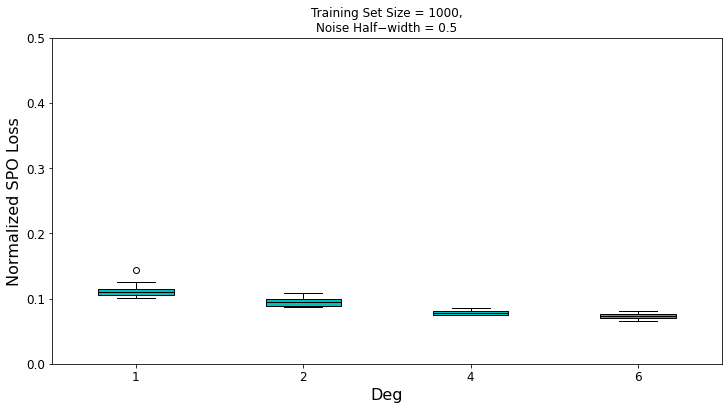

In [23]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df4, boxprops=dict(facecolor='c', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 1000,\nNoise Half−width = 0.5')
plt.show()

## Save File 

In [24]:
df1.to_csv('./res/ks/spoplus_n100.csv', index=False)
df2.to_csv('./res/ks/spoplus_n100_noise.csv', index=False)
df3.to_csv('./res/ks/spoplus_n1000.csv', index=False)
df4.to_csv('./res/ks/spoplus_n1000_noise.csv', index=False)